# Complaints analysis NLP - clustering model

## Methodology

The methodology that will be used for clustering complaints data involves several steps. First, the text data will be preprocessed by tokenizing, stemming, and removing stop words. Then, sentence embeddings will be generated using a pre-trained sentence transformer model. The embeddings will be used as input to various clustering algorithms such as KMeans, Hierarchical Clustering, DBSCAN, and Spectral Clustering. The number of clusters and the hyperparameters for each algorithm will be tuned using techniques such as elbow method, silhouette score, or visual inspection of dendrograms. The resulting clusters will be analyzed to identify patterns, topics, and trends in the complaints data. Finally, the results will be evaluated based on the interpretability and coherence of the clusters and their usefulness for informing business decisions. The goal is to use clustering to gain insights into the complaints data and improve customer experience by addressing the most common and pressing issues.

## Types of clustering
Choosing the best clustering algorithm for a complaints dataset depends on several factors such as the size of the dataset, the number of clusters, the similarity measure, and the desired interpretation of the clusters. Here are some of the most commonly used clustering algorithms for NLP tasks and their pros and cons:

**K-Means Clustering:**

- Pros: Simple, fast, and scales well to large datasets. It works well when the number of clusters is known beforehand, and it can handle non-linearly separable data.
- Cons: Requires the number of clusters to be specified beforehand. It can be sensitive to initialization and can converge to suboptimal solutions.

**Hierarchical Clustering:**

- Pros: Produces a dendrogram that shows the hierarchical structure of the data. It can handle any number of clusters, and the dendrogram can provide insights into the relationships between clusters.
- Cons: Computationally intensive and may not scale well to large datasets. It can be sensitive to the choice of linkage method and distance metric.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**

- Pros: Does not require the number of clusters to be specified beforehand. It can identify clusters of arbitrary shape and handle noisy data points.
- Cons: Sensitive to the choice of hyperparameters such as the neighborhood radius and minimum number of points per cluster. It can produce different results for different hyperparameter settings.

**Spectral Clustering:**

- Pros: Can handle non-linearly separable data and produce high-quality clusters. It can be faster and more accurate than other clustering algorithms in some cases.
- Cons: Requires the computation of a similarity matrix and the eigendecomposition of the Laplacian matrix, which can be computationally expensive for large datasets. It may also require tuning of hyperparameters such as the number of clusters and the similarity measure.
In summary, each clustering algorithm has its own strengths and weaknesses, and the best choice depends on the specific characteristics of the data and the task. For complaints dataset, I would recommend trying hierarchical clustering or DBSCAN as they can handle noisy data and identify clusters of arbitrary shape, which may be useful for identifying patterns of complaints. However, it's always a good idea to experiment with different algorithms and hyperparameters and evaluate the results to determine the best approach for your use case.

In [22]:
# General packages
import pandas as pd
import numpy as np
import os
from datetime import datetime

# Modelling packages
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from scipy.cluster.hierarchy import dendrogram, linkage

# Packages for saving models
import pickle
from joblib import dump

# Plotting packages
import matplotlib.pyplot as plt

# Set to show all columns and max 50 rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [31]:
def save_model_pickle(model, output_dir, file_name):
    """
    Saves a scikit-learn model to a pickle file with a specified output directory and file name.
    
    Parameters:
    -----------
    model : scikit-learn model object
        The scikit-learn model object to save.
    output_dir : str
        The output directory to save the model file in.
    file_name : str
        The name to use for the pickle file. The '.pkl' extension will be added automatically.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Add '.pkl' extension to file name
    file_path = os.path.join(output_dir, file_name + '.pkl')
    
    # Save model to pickle file
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)

def save_model_joblib(model, output_dir, file_name):
    """
    Saves a scikit-learn model to a joblib file.
    
    Parameters:
    -----------
    model : scikit-learn model object
        The scikit-learn model object to save.
    file_name : str
        The name to use for the joblib file. The '.joblib' extension will be added automatically.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Add '.joblib' extension to file name
    file_path = os.path.join(output_dir, file_name + '.joblib')
    
    # Save model to joblib file
    dump(model, file_path)

In [2]:
df = pd.read_parquet('data\complaints_embeddings.pq')

In [3]:
df.head()

,date_received,product,sub-product,issue,sub-issue,consumer_complaint,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,unnamed:_18,sentiment,consumer_complaint_clean,token_list,token_no_stopword,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,2017-02-18,Credit card,None,Credit line increase/decrease,None,"Without provocation, I received notice that my...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,606XX,None,Consent provided,Web,2017-02-18,Closed with explanation,Yes,No,2349987,NaN,0.8074,without provocation i received notice that my ...,"[without, provocation, i, received, notice, th...","[without, provocation, received, notice, credi...",0.002760,0.026967,-0.042018,-0.016628,0.007734,0.024137,-0.021826,-0.019264,-0.011796,0.029838,-0.034672,-0.057657,0.042841,0.041823,-0.048617,0.080814,-0.012033,0.017908,0.008306,0.028105,0.039487,0.037404,0.020370,0.025332,-0.064036,0.015811,0.003834,-0.064116,-0.029

In [4]:
df['0']

0        0.002760
1        0.014006
2        0.054776
3        0.012988
4        0.019980
           ...   
50915    0.047342
50916    0.056133
50917    0.056030
50918    0.031870
50919    0.026797
Name: 0, Length: 50920, dtype: float32

In [5]:
def get_embedding_features(df_in, n_features):
    """
    Extract sentence embeddings from a DataFrame, convert the column names from string to integer,
    and return a DataFrame of embeddings, and date without embeddings.

    Args:
        df (pandas.DataFrame): DataFrame containing text data.
        num_features (int): Number of embedding features to extract.

    Returns:
        df_embeddings pandas.DataFrame: DataFrame of embeddings with integer column names.
        df_data pandas.DataFrame: DataFrame of date without embeddings

    """
    embed_features_int = list(range(0,n_features))
    embed_features_str = []

    for feature in embed_features_int:
        embed_features_str.append(str(feature))

    replacement_dict = dict(zip(embed_features_int, embed_features_str))

    # get embedding cols

    df_embeddings = df_in[embed_features_str]
    df_embeddings = df_embeddings.rename(columns=replacement_dict)

    df_data = df_in.drop(columns=embed_features_str)

    return df_embeddings, df_data

df_embeddings, df_complaints = get_embedding_features(df_in=df, n_features=768)

In [11]:
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.002760,0.026967,-0.042018,-0.016628,0.007734,0.024137,-0.021826,-0.019264,-0.011796,0.029838,-0.034672,-0.057657,0.042841,0.041823,-0.048617,0.080814,-0.012033,0.017908,0.008306,0.028105,0.039487,0.037404,0.020370,0.025332,-0.064036,0.015811,0.003834,-0.064116,-0.029802,-0.025391,0.012703,0.014734,0.078039,-0.037214,0.000002,-0.058571,-0.010742,0.031205,-0.050724,0.006214,0.037399,-0.001269,0.013424,0.003277,-0.045383,0.006867,-0.014168,0.012050,0.030599,-0.008017,-0.000977,-0.018015,-0.035199,-0.002092,-0.027038,0.026679,-0.012523,0.017262,-0.039116,-0.043328,-0.012567,-0.011953,0.034217,0.002909,-0.048914,-0.013898,-0.052836,-0.024120,0.014253,0.011731,-0.012949,0.000079,-0.026083,0.037549,-0.009220,-0.039712,-0.000977,0.029169,-0.008348,0.021101,-0.055616,0.002995,-0.034630,-0.067198,-0.014765,0.012179,0.015861,-0.014580,0.001920,-0.013364,0.001043,-0.002338,-0.018395,0.011542,-0.014619,-0.018805,-0.002075,-0.005382,0.070597,0.018164,0.060822,0.041642,0.024346,-0.030223,0.066807,0.074644,-0.021234,0.005237,-0.08662

In [12]:
df_complaints.head()

,date_received,product,sub-product,issue,sub-issue,consumer_complaint,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,unnamed:_18,sentiment,consumer_complaint_clean,token_list,token_no_stopword
0,2017-02-18,Credit card,None,Credit line increase/decrease,None,"Without provocation, I received notice that my...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,606XX,None,Consent provided,Web,2017-02-18,Closed with explanation,Yes,No,2349987,NaN,0.8074,without provocation i received notice that my ...,"[without, provocation, i, received, notice, th...","[without, provocation, received, notice, credi..."
1,2015-07-20,Mortgage,FHA mortgage,"Loan servicing, payments, escrow account",None,I had an FHA loan at US Bank that was paid off...,Company chooses not to provide a public response,U.S. BANCORP,TN,370XX,None,Consent provided,Web,2015-07-20,Closed with explanation,Yes,No,1474887,NaN,0.3818,i had an fha loan at us bank that was paid off...,"[i, had, an, fha, loan, at, us, bank, that, wa...","[fha, loan, us, bank, paid, 2015, paying, loan..."
2,2016-06-28,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",None,I went through a divorce several years ago and...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",OH,443XX,None,Consent provided,Web,2016-06-28,Closed with explanation,Yes,No,1987818,NaN,-0.7692,i went through a divorce several years ago and...,"[i, went, through, a, divorce, several, years,...","[went, divorce, several, years, ago, requested..."
3,2016-09-02,Credit card,None,Rewards,None,Signed up for the American Express XXXX Card w...,None,AMERICAN EXPRESS COMPANY,AZ,864XX,Servicemember,Consent provided,Web,2016-09-02,Closed with non-monetary relief,Yes,No,2094460,NaN,0.9687,signed up for the american express card when...,"[signed, up, for, the, american, express, card...","[signed, american, express, card, points, bonu..."
4,2017-04-12,Bank account or service,Checking account,Problems caused by my funds being low,None,I have documentation that shows that US Bank w...,Company has responded to the consumer and the ...,U.S. BANCORP,CA,928XX,None,Consent provided,Web,2017-04-12,Closed with explanation,Yes,No,2431565,NaN,-0.8826,i have documentation that shows that us bank w...,"[i, have, documentation, that, shows, that, us...","[documentation, shows, us, bank, would, charge..."


# K-Means clustering

Clustering is an unsupervised learning method that groups together similar data points based on their features. In the context of consumer complaints, clustering can help identify common themes and patterns in the complaints, such as specific issues or products that are frequently reported. This can provide valuable insights into the most pressing issues faced by consumers, and help companies prioritize their efforts to address them.

To determine the optimal number of clusters for KMeans clustering, we can use the elbow method and Davies-Bouldin score. The elbow method involves plotting the within-cluster sum of squares (WCSS) for different numbers of clusters, and selecting the number of clusters at the "elbow" of the plot, which corresponds to the point of diminishing returns in terms of clustering performance. The Davies-Bouldin score is another metric that measures the average similarity between each cluster and its most similar cluster, with lower scores indicating better clustering. By evaluating both of these metrics for a range of cluster numbers, we can identify the number of clusters that provides the best balance between clustering performance and interpretability.

In [19]:
def evaluate_kmeans_clusters(X, min_clusters=2, max_clusters=20):
    """
    Evaluates the optimal number of clusters for KMeans clustering using the elbow method and Davies-Bouldin score.
    
    Parameters:
    -----------
    X : array-like or sparse matrix, shape (n_samples, n_features)
        The input data to cluster.
    min_clusters : int, default=2
        The minimum number of clusters to evaluate.
    max_clusters : int, default=20
        The maximum number of clusters to evaluate.
    
    Returns:
    --------
    kmeans_model : KMeans object
        The KMeans model with the optimal number of clusters.
    elbow_plot : matplotlib plot
        A plot of the within-cluster sum of squares (WCSS) for each number of clusters.
    db_score_plot : matplotlib plot
        A plot of the Davies-Bouldin score for each number of clusters.
    """
    # Initialize lists to store results
    wcss = []
    db_scores = []
    k_values = range(min_clusters, max_clusters+1)
    
    # Iterate over a range of k values
    for k in k_values:
        # Fit KMeans model with k clusters and compute within-cluster sum of squares (WCSS)
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        wcss.append(kmeans.inertia_)
        
        # Compute Davies-Bouldin score
        db_score = davies_bouldin_score(X, kmeans.labels_)
        db_scores.append(db_score)
        
    # Determine the optimal number of clusters using the elbow method
    elbow_point = np.argmin(np.diff(wcss)) + 1
    optimal_k = elbow_point + min_clusters - 1
    
    # Create plots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.subplots_adjust(wspace=0.3)
    
    # Plot WCSS vs. number of clusters
    elbow_plot = ax[0].plot(k_values, wcss, marker='o')
    ax[0].set_title('Within-Cluster Sum of Squares (WCSS)')
    ax[0].set_xlabel('Number of Clusters')
    ax[0].set_ylabel('WCSS')
    ax[0].axvline(x=optimal_k, linestyle='--', color='gray')
    ax[0].text(optimal_k+0.5, wcss[optimal_k-min_clusters], 'Optimal k={}'.format(optimal_k))
    
    # Plot Davies-Bouldin score vs. number of clusters
    db_score_plot = ax[1].plot(k_values, db_scores, marker='o')
    ax[1].set_title('Davies-Bouldin Score')
    ax[1].set_xlabel('Number of Clusters')
    ax[1].set_ylabel('DB Score')
    
    return kmeans, elbow_plot, db_score_plot

c:\Users\hjurz\.conda\envs\env_complaints_nlp\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hjurz\.conda\envs\env_complaints_nlp\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hjurz\.conda\envs\env_complaints_nlp\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hjurz\.conda\envs\env_complaints_nlp\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

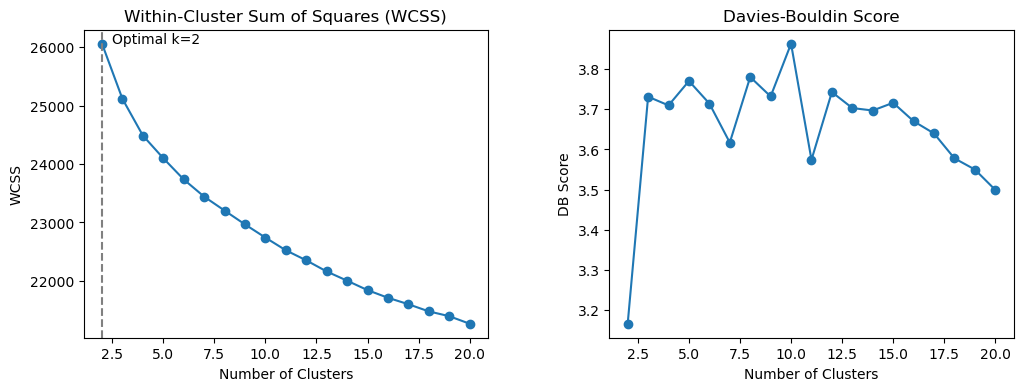

In [21]:
kmeans, elbow_plot, db_score_plot = evaluate_kmeans_clusters(df_embeddings, min_clusters=2, max_clusters=20)

## Train final model on optimal number of clusters
This function trains a final KMeans clustering model on the specified optimal number of clusters and returns the trained model and predicted cluster labels for each input data point. KMeans clustering is an unsupervised learning technique that groups together similar data points based on their features. By training a KMeans model on the sentence embeddings of the consumer complaints dataset, we can identify common themes and patterns in the complaints, such as specific issues or products that are frequently reported. The number of clusters to use is determined using the elbow method and Davies-Bouldin score, which provide a balance between clustering performance and interpretability. The output of this function can be used for further analysis or visualization of the clustered data.

def train_kmeans_model(X, n_clusters):
    """
    Trains a KMeans clustering model on the input data with the specified number of clusters.
    
    Parameters:
    -----------
    X : array-like or sparse matrix, shape (n_samples, n_features)
        The input data to cluster.
    n_clusters : int
        The number of clusters to use for KMeans clustering.
    
    Returns:
    --------
    kmeans_model : KMeans object
        The trained KMeans model.
    scored_data : array-like, shape (n_samples,)
        The predicted cluster labels for each input data point.
    """
    # Fit KMeans model with specified number of clusters
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    
    # Predict cluster labels for input data
    scored_data = kmeans_model.predict(X)
    
    return kmeans_model, scored_data

n_clusters = 10
kmeans, k = train_kmeans_model(df_embeddings, n_clusters)

file_name = 'kmeans_model_' + str(n_clusters) + "_" + datetime.now().strftime("%Y-%m-%d %H:%M")
output_dir = 'models\\'
save_model_joblib(kmeans, output_dir, file_name)
save_model_joblib(kmeans, output_dir, file_name)

# DBSCAN clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups together points that are closely packed together in high-density regions, while marking outliers and points in low-density regions as noise. The algorithm works by defining a neighborhood around each point, based on a distance measure, and then counting the number of points in each neighborhood. Points that have at least a minimum number of points in their neighborhood are considered to be part of a cluster, while points with fewer points in their neighborhood are marked as noise.

In the context of consumer complaints clustering, DBSCAN can be used to identify groups of complaints that share similar characteristics and may have similar underlying causes. For example, DBSCAN could be used to identify clusters of complaints that relate to specific products or services, or clusters of complaints that share common themes or language.

DBSCAN has several advantages over other clustering algorithms. One key advantage is that it does not require the user to specify the number of clusters in advance, unlike methods such as k-means or hierarchical clustering. DBSCAN is also robust to noise and can handle clusters of arbitrary shape and size, making it well-suited for clustering high-dimensional data such as text.

However, DBSCAN has some limitations. The algorithm requires careful tuning of its hyperparameters, including the minimum number of points in a neighborhood and the maximum distance between points. The choice of these hyperparameters can have a significant impact on the clustering results, and selecting appropriate values can require some trial and error. Additionally, DBSCAN can struggle with clusters of varying densities or with data sets that have widely varying densities. In the context of consumer complaints, this could mean that some clusters may be poorly defined or that some complaints may be misclassified as noise.



In DBSCAN (Density-Based Spatial Clustering of Applications with Noise), eps is a hyperparameter that represents the maximum distance between two samples for them to be considered as in the same neighborhood. This hyperparameter is critical in determining the size and shape of the clusters that are identified by the algorithm.

When eps is too small, points that should be in the same cluster may be identified as noise or assigned to separate clusters. On the other hand, when eps is too large, many points may be grouped together into a single cluster, leading to under-segmentation.

Therefore, choosing an appropriate eps value is important for obtaining good clustering results. One common approach is to use a distance plot or a k-distance graph to visualize the distances between each point and its k-th nearest neighbor. The elbow point in the plot can be used as a reference for selecting a suitable eps value.

In [38]:

def dbscan_clustering(X, eps=0.5, min_samples=5, plot_metrics=True):
    """
    Trains a DBSCAN clustering model on input data and evaluates the clustering using silhouette score, 
    Calinski-Harabasz index, and Davies-Bouldin index. Plots the results if specified.
    
    Parameters:
    -----------
    X : numpy array or pandas DataFrame
        The input data to cluster.
    eps : float, optional (default=0.5)
        The maximum distance between two samples for them to be considered as in the same neighborhood.
    min_samples : int, optional (default=5)
        The number of samples in a neighborhood for a point to be considered as a core point.
    plot_metrics : bool, optional (default=True)
        Whether to plot the evaluation metrics.
    
    Returns:
    --------
    model : DBSCAN object
        The trained DBSCAN clustering model.
    labels : numpy array
        The cluster labels for each data point.
    """
    # Train DBSCAN model on data
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X)
    
    # Evaluate DBSCAN clustering using silhouette score, Calinski-Harabasz index, and Davies-Bouldin index
    silhouette = silhouette_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    
    # Print evaluation metrics
    print('Silhouette score:', silhouette)
    print('Calinski-Harabasz index:', calinski_harabasz)
    print('Davies-Bouldin index:', davies_bouldin)
    
    # Plot evaluation metrics
    if plot_metrics:
        metrics = ['Silhouette score', 'Calinski-Harabasz index', 'Davies-Bouldin index']
        values = [silhouette, calinski_harabasz, davies_bouldin]
        x_pos = np.arange(len(metrics))
        
        plt.bar(x_pos, values, align='center', color='steelblue')
        plt.xticks(x_pos, metrics)
        plt.title('DBSCAN clustering evaluation metrics')
        plt.show()
    

    return model, labels

Silhouette score: -0.23696113
Calinski-Harabasz index: 17.942193243415215
Davies-Bouldin index: 1.9176168099223663


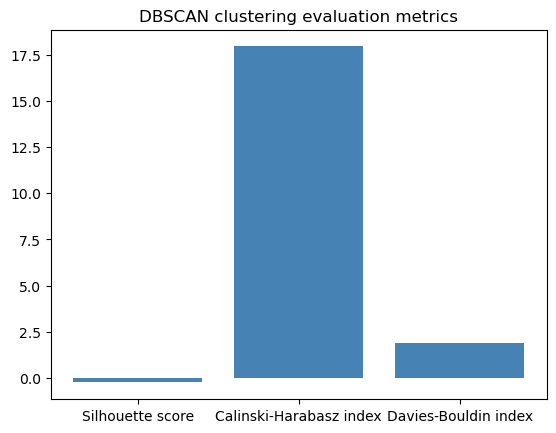

InvalidIndexError: (slice(None, None, None), 0)

In [39]:
dbscan, dbscan_labels = dbscan_clustering(df_embeddings, eps=0.5, min_samples=5, plot_metrics=True)

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Compute k-distance graph
k = 4
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
distances, indices = nbrs.kneighbors(X)
k_distances = distances[:, -1]
k_distances_sorted = np.sort(k_distances)

# Plot distance graph
plt.plot(k_distances_sorted)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('k-Distance Graph')
plt.show()

# Spectral clustering

Spectral clustering is a powerful technique that is well-suited for clustering high-dimensional data, such as text data in consumer complaints. One advantage of spectral clustering is that it can handle data sets with complex structures and non-linear decision boundaries, which are common in text data. Additionally, spectral clustering can handle data sets with a small number of clusters, as well as data sets with clusters of different shapes and sizes.

In the context of consumer complaints clustering, spectral clustering can be used to identify groups of complaints that share similar characteristics and may have similar underlying causes. By grouping similar complaints together, we can gain insights into the common issues and concerns that customers have, and identify areas where improvements can be made. Additionally, spectral clustering can help us to identify any outliers or anomalies in the complaints data set, which may represent unusual or unique issues that require further investigation. Overall, spectral clustering is a useful tool for analyzing consumer complaints data and can help organizations to improve their products and services based on customer feedback.

In [7]:

def spectral_clustering(X, n_clusters):
    """
    Performs spectral clustering on a given data set X.

    Args:
        X (array-like): The input data set.
        n_clusters (int): The number of clusters to generate.

    Returns:
        array-like: An array of cluster labels for each data point.
    """

    # Create spectral clustering object and fit to data
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', eigen_solver='arpack')
    labels = spectral.fit_predict(X)

    return labels

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 5

In [ ]:
def evaluate_spectral_clustering(X, labels):
    """
    Evaluates the output of spectral clustering using the silhouette score and Davies-Bouldin index.

    Args:
        X (array-like): The input data set.
        labels (array-like): The array of cluster labels for each data point.

    Returns:
        tuple: A tuple of the silhouette score and Davies-Bouldin index.
    """

    # Compute silhouette score
    silhouette = silhouette_score(X, labels)

    # Compute Davies-Bouldin index
    db = davies_bouldin_score(X, labels)

    return silhouette, db

In [ ]:
def spectral_clustering(X, n_clusters_range):
    """
    Performs spectral clustering for a range of cluster numbers and evaluates the clustering results.

    Args:
        X (array-like): The input data set.
        n_clusters_range (range): A range of cluster numbers to evaluate.

    Returns:
        tuple: A tuple of the dendrogram, scatter plot, and cluster labels for the best clustering result.
    """

    # Perform spectral clustering for different numbers of clusters
    best_silhouette = -1
    best_db = np.inf
    best_labels = None
    for n_clusters in n_clusters_range:
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)
        labels = model.fit_predict(X)
        silhouette, db = evaluate_spectral_clustering(X, labels)
        if silhouette > best_silhouette and db < best_db:
            best_silhouette = silhouette
            best_db = db
            best_labels = labels

    # Compute linkage and dendrogram
    Z = linkage(X, method='ward')
    plt.figure(figsize=(10, 5))
    plt.title('Hierarchical Clustering Dendrogram')
    dendrogram(Z)
    plt.show()

    # Plot scatter plot of two largest principal components
    plt.figure(figsize=(10, 5))
    plt.scatter(X[:, 0], X[:, 1], c=best_labels, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()

    return Z, best_labels

In [ ]:
Z, best_labels = spectral_clustering(df_embeddings, range(2,10))

# Hierarchical clusting

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

def hierarchical_clustering(X):
    """
    Performs hierarchical clustering using the Ward linkage method and evaluates the clustering results.

    Args:
        X (array-like): The input data set.

    Returns:
        tuple: A tuple of the dendrogram, scatter plot, and cluster labels for the best clustering result.
    """

    # Perform hierarchical clustering using Ward linkage
    Z = linkage(X, method='ward')

    # Compute cluster labels using dendrogram
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
    model.fit(Z)
    best_labels = model.labels_

    # Plot dendrogram
    plt.figure(figsize=(10, 5))
    plt.title('Hierarchical Clustering Dendrogram')
    dendrogram(Z)
    plt.show()

    # Plot scatter plot of two largest principal components
    plt.figure(figsize=(10, 5))
    plt.scatter(X[:, 0], X[:, 1], c=best_labels, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()

    return Z, best_labels

In [ ]:
z, labels = hierarchical_clustering(df_embeddings)

In [ ]:
# Compare all models

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
import matplotlib.pyplot as plt

def compare_clustering(X, labels_kmeans, labels_dbscan, labels_spectral):
    """
    Compares the clustering results of KMeans, DBSCAN, and spectral clustering using different evaluation metrics.

    Args:
        X (array-like): The input data set.
        labels_kmeans (array-like): The cluster labels from KMeans clustering.
        labels_dbscan (array-like): The cluster labels from DBSCAN clustering.
        labels_spectral (array-like): The cluster labels from spectral clustering.

    Returns:
        None
    """
    # Compute evaluation metrics for KMeans clustering
    s_score_kmeans = silhouette_score(X, labels_kmeans)
    ch_score_kmeans = calinski_harabasz_score(X, labels_kmeans)
    db_score_kmeans = davies_bouldin_score(X, labels_kmeans)

    # Compute evaluation metrics for DBSCAN clustering
    s_score_dbscan = silhouette_score(X, labels_dbscan)

    # Compute evaluation metrics for spectral clustering
    s_score_spectral = silhouette_score(X, labels_spectral)
    ch_score_spectral = calinski_harabasz_score(X, labels_spectral)
    db_score_spectral = davies_bouldin_score(X, labels_spectral)

    # Print evaluation metrics
    print('KMeans clustering:')
    print('Silhouette score:', s_score_kmeans)
    print('Calinski-Harabasz score:', ch_score_kmeans)
    print('Davies-Bouldin score:', db_score_kmeans)
    print('\n')

    print('DBSCAN clustering:')
    print('Silhouette score:', s_score_dbscan)
    print('\n')

    print('Spectral clustering:')
    print('Silhouette score:', s_score_spectral)
    print('Calinski-Harabasz score:', ch_score_spectral)
    print('Davies-Bouldin score:', db_score_spectral)
    print('\n')

    # Plot scatter plot of the data points colored by true and predicted labels
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax2.scatter(X[:, 0], X[:, 1], c=labels_kmeans, cmap='viridis')
    ax2.set_title('KMeans labels')
    ax3.scatter(X[:, 0], X[:, 1], c=labels_dbscan, cmap='viridis')
    ax3.set_title('DBSCAN labels')
    plt.show()

    # Plot dendrogram for hierarchical clustering
    Z, _ = hierarchical_clustering(X)
    plt.figure(figsize=(10, 5))
    dendrogram(Z)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.show()